## Preparation
Make the file structure:

In [1]:
import os, shutil

base_dir = 'data_small'

def rm_dir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(base_dir)

rm_dir(base_dir)

def make_dir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

make_dir(base_dir)

train_dir = os.path.join(base_dir, 'train')
make_dir(train_dir)

train_x_dir = os.path.join(train_dir, 'x')
make_dir(train_x_dir)

train_y_dir = os.path.join(train_dir, 'y')
make_dir(train_y_dir)

val_dir = os.path.join(base_dir, 'val')
make_dir(val_dir)

val_x_dir = os.path.join(val_dir, 'x')
make_dir(val_x_dir)

val_y_dir = os.path.join(val_dir, 'y')
make_dir(val_y_dir)

test_dir = os.path.join(base_dir, 'test')
make_dir(test_dir)

Copy over some images. Our x's are images, while our y's are labels:

In [2]:
import random

total_size = 100
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)

file_names = random.sample(os.listdir('data/training/images'), train_size)

def clear_dir(dir_name):
    file_names = os.listdir(dir_name)
    
    for file_name in file_names:
        os.remove(os.path.join(dir_name, file_name))

def copy_files(src_dir, dest_dir, file_names):
    for file_name in file_names:
        shutil.copy(os.path.join(src_dir, file_name), dest_dir)

clear_dir(train_x_dir)
copy_files('data/training/images', train_x_dir, file_names)

def set_ext(file_name, ext):
    return os.path.splitext(file_name)[0] + ext

clear_dir(train_y_dir)
copy_files('data/training/v2.0/labels', train_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/validation/images'), val_size)
clear_dir(val_x_dir)
copy_files('data/validation/images', val_x_dir, file_names)
clear_dir(val_y_dir)
copy_files('data/validation/v2.0/labels', val_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/testing/images'), test_size)
clear_dir(test_dir)
copy_files('data/testing/images', test_dir, file_names)

What does an input and its label look like? Let's convert them into tensors and display them:

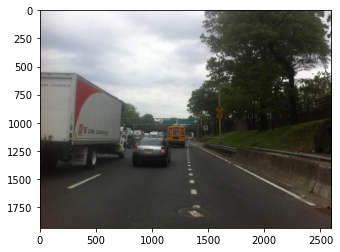

img.shape: (1936, 2592, 3)


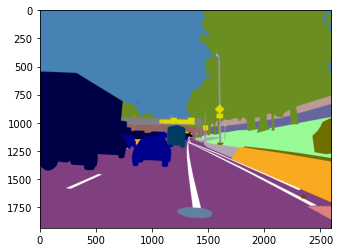

label.shape: (1936, 2592, 3)


In [3]:
from keras import utils
import matplotlib.pyplot as plt

file_name = os.listdir(train_x_dir)[0]
img = utils.load_img(os.path.join(train_x_dir, file_name))
img = utils.img_to_array(img)
img /= 255

plt.imshow(img)
plt.show()
print('img.shape: ' + str(img.shape))

file_name = os.listdir(train_y_dir)[0]
label = utils.load_img(os.path.join(train_y_dir, file_name))
label = utils.img_to_array(label)
label /= 255
plt.imshow(label)
plt.show()
print('label.shape: ' + str(label.shape))

Enumerating the categories makes arbitrary values, while one-hot encoding (one matrix per category) is high-dimensional and sparse. For this reason we'll use an autoencoder to automatically encode the categories. Unfortunately, Keras models require constant input shapes, so we'll pick a shape that's close to that of the inputs:

In [11]:
from keras import models
from keras import layers
from keras import optimizers

input_shape = (1024, 1024, 3)

encoder = models.Sequential()
encoder.add(layers.Conv2D(4, kernel_size=3, padding='same', activation='selu', input_shape=input_shape))
encoder.add(layers.MaxPool2D(pool_size=2))

decoder = models.Sequential()
decoder.add(layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='softmax'))

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss='binary_crossentropy', optimizer=optimizers.Adam())
autoencoder.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_19 (Sequential)  (None, 511, 511, 4)       112       
                                                                 
 sequential_20 (Sequential)  (None, 1022, 1022, 3)     111       
                                                                 
Total params: 223
Trainable params: 223
Non-trainable params: 0
_________________________________________________________________


Let's start training:

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10

def get_gen(x_dir, y_dir):
    x_gen = datagen.flow_from_directory(
        x_dir,
        target_size=input_shape,
        batch_size=batch_size,
        class_mode=None
    )
    
    y_gen = datagen.flow_from_directory(
        y_dir,
        target_size=input_shape,
        batch_size=batch_size,
        class_mode=None
    )
    
    return zip(x_gen, y_gen)

train_gen = get_gen(train_x_dir, train_y_dir)
val_gen = get_gen(val_x_dir, val_y_dir)

history = autoencoder.fit(
    train_gen,
    steps_per_epoch=train_size/batch_size,
    epochs=16,
    validation_data=val_gen,
    validation_steps=val_size/batch_size
)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Epoch 1/16


ValueError: in user code:

    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_19" (type Sequential).
    
    Input 0 of layer "max_pooling2d_7" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, None, None, None, 4)
    
    Call arguments received by layer "sequential_19" (type Sequential):
      • inputs=tf.Tensor(shape=(None, None, None, None, None), dtype=float32)
      • training=True
      • mask=None
